In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# load data

In [12]:
BASE_DIR = '/home/lzhao/data/tmp/optiver'

In [13]:
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
book_example = pd.read_parquet(os.path.join(BASE_DIR, 'book_train.parquet/stock_id=0'))
trade_example = pd.read_parquet(os.path.join(BASE_DIR, 'trade_train.parquet/stock_id=0'))

In [14]:
train_df.head(5)

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [15]:
len(train_df.stock_id.unique())

112

In [17]:
book_test = book_example[book_example.time_id == 5]
book_test

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3


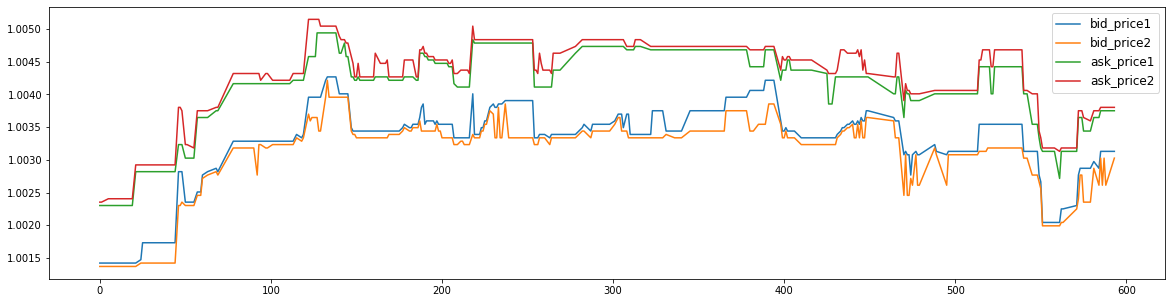

In [18]:
samples = ['bid_price1', 'bid_price2', 'ask_price1', 'ask_price2']
plt.figure(figsize=(20, 5))
for key in samples:
    plt.plot(book_test.seconds_in_bucket, book_test[key], label=key)
plt.legend(fontsize=12)
